In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
import os
import keras
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings("ignore")

# The following data are obtained from https://github.com/hwchase17/sportvu

data13 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2013.csv")
data13['season'] = ['2013' for _ in range(len(data13))]
data14 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2014.csv")
data14['season'] = ['2014' for _ in range(len(data14))]


data = pd.concat([data13,data14],ignore_index=True)
data = data[data["TOUCH_TIME"] >= 0]


Using TensorFlow backend.


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# if you want to use the pre-trained model the variable TRAIN_MODEL should be set to FALSE
TRAIN_MODEL = False

if TRAIN_MODEL:

    data = data[["CLOSE_DEF_DIST","DRIBBLES","SHOT_DIST","SHOT_CLOCK","TOUCH_TIME","CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE","SHOT_MADE_FLAG",'season']]
    data = pd.get_dummies(data,columns=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"],prefix=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"])
    data = data.dropna()
    data = data[data['season'] == '2013']

    data = data.drop(['season'], axis = 1)

    train_X = data.drop(['SHOT_MADE_FLAG'],axis = 1)
    train_y = to_categorical(data['SHOT_MADE_FLAG'])


    early_stopping_monitor = EarlyStopping(patience=3,min_delta = 0.01,monitor='val_acc')
    model_check_point = ModelCheckpoint("shot_make_model/model_sm.{epoch:02d}-{val_acc:.2f}.hdf5",monitor = 'val_acc',mode = 'max',save_best_only = True)

    model= Sequential()
    n_cols = train_X.shape[1]
    model.add(Dense(250, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_X, train_y, epochs=5,validation_split=0.2, callbacks=[model_check_point,early_stopping_monitor])

Test set accuracy:  0.6540393109886156
The model's brier score is:  0.2161382274437964
The climatology's brier score is:  0.24782561508100734


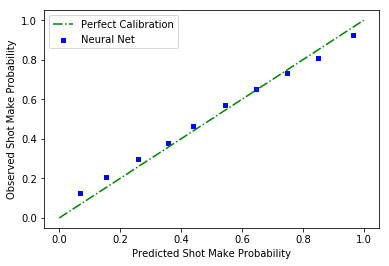

In [3]:
# out-of-sample accuracy (2014-15 season)

# load the best model based on the validation set and the early stopping
m = [f for f in sorted(os.listdir('shot_make_model')) if 'hdf5' in f][-1]
model = keras.models.load_model('shot_make_model/'+m)

# reload the data for both seasons in order to create the correct dummy variables 
data13 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2013.csv")
data13['season'] = ['2013' for _ in range(len(data13))]
data14 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2014.csv")
data14['season'] = ['2014' for _ in range(len(data14))]
data = pd.concat([data13,data14],ignore_index=True)
data = data[data["TOUCH_TIME"] >= 0]
test = data
test = test[["CLOSE_DEF_DIST","DRIBBLES","SHOT_DIST","SHOT_CLOCK","TOUCH_TIME","CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE","SHOT_MADE_FLAG","season"]]
test = pd.get_dummies(test,columns=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"],prefix=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"])
test = test[test['season']== '2014']
test = test.drop(['season'],axis = 1)
test = test.dropna()

test_X = test.drop(['SHOT_MADE_FLAG'],axis =1)
test_y = to_categorical(test['SHOT_MADE_FLAG'])
test_y_predictions = model.predict(test_X)

print("Test set accuracy: ",np.sum(np.round(test_y_predictions[:,1]) == test['SHOT_MADE_FLAG'])/test.shape[0])

# brier score

print("The model's brier score is: ",  brier_score_loss(test['SHOT_MADE_FLAG'],test_y_predictions[:,1]))
print("The climatology's brier score is: ", brier_score_loss(test['SHOT_MADE_FLAG'],(sum(test['SHOT_MADE_FLAG'])/len(test))*np.ones(test.shape[0])))

observed, predicted = calibration_curve(test['SHOT_MADE_FLAG'], test_y_predictions[:,1], n_bins = 10)

fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.linspace(0,1,10000)
y = x
ax1.plot(x,y,'-.g',label="Perfect Calibration")

ax1.scatter(predicted,observed,s=20, c='b', marker="s", label = "Neural Net")


plt.xlabel("Predicted Shot Make Probability")
plt.ylabel("Observed Shot Make Probability")
plt.legend(loc='upper left');
plt.show()

In [4]:
SHOT_THRES = 1000

data13 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2013.csv")
data13['season'] = ['2013' for _ in range(len(data13))]
data14 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2014.csv")
data14['season'] = ['2014' for _ in range(len(data14))]
data = pd.concat([data13,data14],ignore_index=True)
data = data[data["TOUCH_TIME"] >= 0]
test = data
test = test[test['season']== '2014']
test = test.dropna()
test['prob'] = test_y_predictions[:,1]

shots_pl = test.groupby('PLAYER_ID')

players = []

for p in test['PLAYER_ID'].unique():
    if len(shots_pl.get_group(p)) > SHOT_THRES:
        players.append(p)

for p in players: 
    player_df = shots_pl.get_group(p)
    player_df_games = player_df.groupby("GAME_ID")
    tt_true = 0
    tf_true = 0
    # find the games that we have full data for the player
    games_p = []
    good_shots = 0
    for g in player_df['GAME_ID'].unique():
        tmp = player_df_games.get_group(g)
        if len(tmp.SHOT_NUMBER)-max(tmp.SHOT_NUMBER)==0:
            games_p.append(g)
            good_shots += len(tmp.SHOT_NUMBER)
            
    if good_shots < 500:
        continue
            
    for g in games_p:
        tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
        for i in range(len(list(tmp))-1):
            if list(tmp)[i] == 1:
                if list(tmp)[i+1] == 1:
                    tt_true+=1
                else:
                    tf_true+=1
    tt_prob_sim = []
    for _ in range(500):
        tt_sim=0
        tf_sim=0
        for g in games_p:
            # sample binomial for each shot
            probs = list(player_df_games.get_group(g)['prob'])
            tmp = [np.random.binomial(1,probs[i]) for i in range(len(probs))]
            for i in range(len(list(tmp))-1):
                if list(tmp)[i] == 1:
                    if list(tmp)[i+1] == 1:
                        tt_sim += 1
                    else:
                        tf_sim+=1
        tt_prob_sim.append(tt_sim/(tt_sim+tf_sim))
    print(data[data['PLAYER_ID'] == p].reset_index().iloc[0]['PLAYER_NAME'],",",tt_true/(tt_true+tf_true),",",np.mean(tt_prob_sim),",",0.002*len([tt_prob_sim[i] for i in range(len(tt_prob_sim)) if tt_prob_sim[i]>(tt_true/(tt_true+tf_true))]))



LaMarcus Aldridge , 0.46984126984126984 , 0.439379598580671 , 0.146
Rudy Gay , 0.4931129476584022 , 0.40619918089176527 , 0.0
Pau Gasol , 0.46176470588235297 , 0.45917192797160417 , 0.46
Chris Paul , 0.4789915966386555 , 0.4128844046510319 , 0.008
Anthony Davis , 0.5104477611940299 , 0.5241311345810927 , 0.704
Damian Lillard , 0.421875 , 0.3718752163629527 , 0.038
Victor Oladipo , 0.42857142857142855 , 0.41708997771352435 , 0.324
LeBron James , 0.46236559139784944 , 0.4773611428402156 , 0.718
Dwyane Wade , 0.4744744744744745 , 0.45812244756471604 , 0.26
Monta Ellis , 0.4444444444444444 , 0.419577414353161 , 0.184
Russell Westbrook , 0.4153846153846154 , 0.36756893434586885 , 0.044
Andrew Wiggins , 0.3935860058309038 , 0.43057497160531366 , 0.928
Blake Griffin , 0.5243619489559165 , 0.4737850777413629 , 0.016
James Harden , 0.4392857142857143 , 0.39892678824287214 , 0.10200000000000001
Tyreke Evans , 0.48201438848920863 , 0.4542252690927556 , 0.17200000000000001
Stephen Curry , 0.464673

In [5]:
# permutation considering them identical 
import random
SHOT_THRES = 1000

data13 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2013.csv")
data13['season'] = ['2013' for _ in range(len(data13))]
data14 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2014.csv")
data14['season'] = ['2014' for _ in range(len(data14))]
data = pd.concat([data13,data14],ignore_index=True)
data = data[data["TOUCH_TIME"] >= 0]
test = data
test = test[test['season']== '2014']
test = test.dropna()
test['prob'] = test_y_predictions[:,1]

shots_pl = test.groupby('PLAYER_ID')

players = []

for p in test['PLAYER_ID'].unique():
    if len(shots_pl.get_group(p)) > SHOT_THRES:
        players.append(p)

for p in players: 
    player_df = shots_pl.get_group(p)
    player_df_games = player_df.groupby("GAME_ID")
    tt_true = 0
    tf_true = 0
    # find the games that we have full data for the player
    games_p = []
    good_shots = 0
    for g in player_df['GAME_ID'].unique():
        tmp = player_df_games.get_group(g)
        if len(tmp.SHOT_NUMBER)-max(tmp.SHOT_NUMBER)==0:
            games_p.append(g)
            good_shots += len(tmp.SHOT_NUMBER)
            
    if good_shots < 500:
        continue
            
    for g in games_p:
        tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
        for i in range(len(list(tmp))-1):
            if list(tmp)[i] == 1:
                if list(tmp)[i+1] == 1:
                    tt_true+=1
                else:
                    tf_true+=1
    tt_prob_sim = []
    for _ in range(500):
        tt_sim=0
        tf_sim=0
        for g in games_p:
            # sample binomial for each shot
            tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
            tmp = random.sample(tmp,len(tmp))
            for i in range(len(list(tmp))-1):
                if list(tmp)[i] == 1:
                    if list(tmp)[i+1] == 1:
                        tt_sim += 1
                    else:
                        tf_sim+=1
        tt_prob_sim.append(tt_sim/(tt_sim+tf_sim))
    print(data[data['PLAYER_ID'] == p].reset_index().iloc[0]['PLAYER_NAME'],",",tt_true/(tt_true+tf_true),",",np.mean(tt_prob_sim),",",0.002*len([tt_prob_sim[i] for i in range(len(tt_prob_sim)) if tt_prob_sim[i]>(tt_true/(tt_true+tf_true))]))




LaMarcus Aldridge , 0.46984126984126984 , 0.47629486682783817 , 0.612
Rudy Gay , 0.4931129476584022 , 0.47288860996202575 , 0.14
Pau Gasol , 0.46176470588235297 , 0.48108362595697235 , 0.842
Chris Paul , 0.4789915966386555 , 0.4842532911799983 , 0.608
Anthony Davis , 0.5104477611940299 , 0.5268847450133491 , 0.8240000000000001
Damian Lillard , 0.421875 , 0.44363726274797044 , 0.84
Victor Oladipo , 0.42857142857142855 , 0.4423235487658536 , 0.728
LeBron James , 0.46236559139784944 , 0.48524641410959996 , 0.86
Dwyane Wade , 0.4744744744744745 , 0.46923218557667734 , 0.384
Monta Ellis , 0.4444444444444444 , 0.45443547983765775 , 0.6960000000000001
Russell Westbrook , 0.4153846153846154 , 0.42317162181091433 , 0.64
Andrew Wiggins , 0.3935860058309038 , 0.41601075654118425 , 0.872
Blake Griffin , 0.5243619489559165 , 0.5073112146533124 , 0.13
James Harden , 0.4392857142857143 , 0.45614438049449935 , 0.762
Tyreke Evans , 0.48201438848920863 , 0.4727786502927994 , 0.322
Stephen Curry , 0.4646

# Figure 1 example

In [6]:
sequence = [1,1,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1]

tt_true = 0
tf_true = 0
for i in range(len(list(sequence))-1):
    if list(sequence)[i] == 1:
        if list(sequence)[i+1] == 1:
            tt_true+=1
        else:
            tf_true+=1
tt_prob_sim = []
for _ in range(500):
    tt_sim=0
    tf_sim=0
    tmp = np.random.permutation(sequence)
    for i in range(len(list(tmp))-1):
        if list(tmp)[i] == 1:
            if list(tmp)[i+1] == 1:
                tt_sim += 1
            else:
                tf_sim+=1
    tt_prob_sim.append(tt_sim/(tt_sim+tf_sim))
print(tt_true/(tt_true+tf_true),np.mean(tt_prob_sim),0.001*len([tt_prob_sim[i] for i in range(len(tt_prob_sim)) if tt_prob_sim[i]>(tt_true/(tt_true+tf_true))]))

0.5555555555555556 0.42135555555555554 0.05


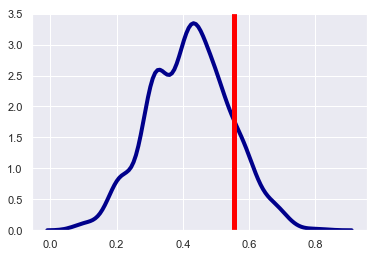

In [7]:
import seaborn as sns, numpy as np

sns.set(); np.random.seed(0)
ax = sns.distplot(tt_prob_sim,hist=False,kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.axvline(0.555, color='red',linewidth=5)